## Project 2 : Topic Modelling

### 1. Introduction

In this project, we carry out topic modelling on a book chosen from the Gutenberg Project.  The Gensim package's tools for topic modelling are used instead of Scikit-Learn because Gensim provides the Coherence model and metrics for evaluating the topic models.  The metric of coherence which we use is known as NPMI (normalized Pointwise Mutual Information).  We also coded another metric which uses Word2Vec embeddings to compute the so-called c_w2v (where "c" stands for "coherence").

### 2. Data Preparation

The book which was chosen is entitled "Gilbert Weather Bureau (Meteorology) for Boys".  The .txt version of the ebook was downloaded from https://www.gutenberg.org/ebooks/67391.txt.utf-8. The book aims to teach children about the weather and describes many experiments which the children are encouraged to follow.

The beginning and ending portions of the text file were removed, because these were the administrative publisher's information and legalese.  The content proper was stored in a file "weather_for_boys.txt" in the data/ subfolder.

Data preparation proceeds to divide the text into paragraphs (or "documents") to facilitate the Tf-Idf Model and Topic modelling.  Paragraphs are identified as portions of text which are divided by 3 or more newlines.  Next, we process the text with the steps: tokenization, lower-casing, removing stopwords, removing non-alphabetic tokens such as numerical information and punctuation, and finally, lemmatization.  We then remove "documents" which have fewer than 10 tokens.  This leaves us with a corpus of 99 documents.

In [1]:
import re
import numpy as np

In [2]:
# read in the book as text string

book_path = "data/weather_for_boys.txt"

with open(book_path, 'r') as f:
    contents = f.read()
    print(contents)

                          WEATHER INDICATIONS
                         A Study of the Weather


In the minds of most people a very silly notion prevails about the
weather and the weather man. They have a general impression that the
weather knows no laws—that it is lawless and reckless, fickle and
changeable; that the weather man is a sort of conjurer, and by some
mysterious gift he is able to prophesy things that most people know
nothing about. Nothing could be further from the truth.

After you have carried out the simple experiments described, and have
read this text, whether you have a scientific trend of mind or not, you
will at least learn that the weather is a science, like electricity,
chemistry, or medicine; that its laws are uniform, constant, and
unchanging, and there is really nothing mysterious about it. The weather
man is a scientist and by means of instruments, which indicate certain
things, he comes to definite conclusions. He is not a prophet; he does
not prophesy; he f

In [3]:
# Split the contents into shorter strings by paragraphs/sections
# where each paragraph is separated by 3 or more newline characters

paragraphs_list =  re.split('\n{3,}', contents)
len(paragraphs_list)

109

In [4]:
paragraphs_list[3]

'                            EXPERIMENT NO. 1\n\nTake the stopper out of a bottle and endeavor to pour water into it\nrapidly and see what happens. (See Fig. 1.) One of the laws in Physics\nis that no two bodies can occupy the same space at the same time. After\ndoing this experiment, you will come to the conclusion that the bottle\ndoes contain something, and that “something” is matter, and that matter\nis air. There is in the bottle probably as important a thing as you\ncould possibly conceive of, because even this earth without its ocean of\nair would be a world of desolation; for air sustains life itself, and\nwhen agitated, develops great strength. It may be whirled about into a\nhurricane blast and assume such violent proportions that villages will\nbe swept away, and great waves of water will be raised, upon which ships\ncan be tossed about like so much chaff. We all know that air can become\nso cold that great suffering will be caused, and so hot that it will\nmake life almost 

In [5]:
# packages for nlp - regex, stopwords and tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# packages for nlp - lemmatization
from nltk.stem import WordNetLemmatizer 

# instantiate the lemmatizer
wn_lemmatizer = WordNetLemmatizer()

# get the English stopwords
stopwords = set( stopwords.words('english') )

In [6]:
# We will lemmatize according to three classes: verbs, adjectives, and nouns.
# The default word class is nouns.
def get_lemma_pos( pos ):
    pos_map = { 'v': 'v', 'j': 'a', 'n': 'n'}
    return pos_map.get( pos.lower()[0], 'n')

In [7]:
# Pre-process the text to prepare for vectorization
def preprocess_lemmatize(review):
    # tokenize
    tokens = word_tokenize(review)
    
    # add the POS - need the tags to properly do the lemmatization by wordnet
    pairs = nltk.pos_tag(tokens)
    
    # lower case the contents of the token-pos pairs
    pairs_lower = [ (pair[0].lower(), pair[1].lower()) for pair in pairs ]
    
    # remove stopwords
    pairs_no_stopwords = [ pair for pair in pairs_lower if pair[0] not in stopwords ]
    # remove tokens that are not fully alphabetic characters - punctuations and numeric 
    alpha_pairs = [ pair for pair in pairs_no_stopwords if pair[0].isalpha() ]
    
    # lemmatize the tokens
    lemmas0 = [ wn_lemmatizer.lemmatize(pair[0], pos=get_lemma_pos( pair[1] ) ) for pair in alpha_pairs ]
    
    # lower case the lemmas
    lemmas = [ str(lemma.lower()) for lemma in lemmas0 ]
                    
    return lemmas

In [8]:
print(preprocess_lemmatize(paragraphs_list[3]))

['experiment', 'take', 'stopper', 'bottle', 'endeavor', 'pour', 'water', 'rapidly', 'see', 'happen', 'see', 'fig', 'one', 'law', 'physic', 'two', 'body', 'occupy', 'space', 'time', 'experiment', 'come', 'conclusion', 'bottle', 'contain', 'something', 'something', 'matter', 'matter', 'air', 'bottle', 'probably', 'important', 'thing', 'could', 'possibly', 'conceive', 'even', 'earth', 'without', 'ocean', 'air', 'would', 'world', 'desolation', 'air', 'sustains', 'life', 'agitate', 'develop', 'great', 'strength', 'may', 'whirl', 'hurricane', 'blast', 'assume', 'violent', 'proportion', 'village', 'sweep', 'away', 'great', 'wave', 'water', 'raise', 'upon', 'ship', 'toss', 'like', 'much', 'chaff', 'know', 'air', 'become', 'cold', 'great', 'suffering', 'cause', 'hot', 'make', 'life', 'almost', 'unbearable', 'really', 'live', 'ocean', 'air', 'illustration', 'fig', 'illustration', 'fig']


In [9]:
# preprocess the paragraphs with wordnet lemmatizer
# Remove paragraphs with fewer than 10 tokens

doc_len = 10
lemma_paras = []

for para in paragraphs_list:
    lemmas = preprocess_lemmatize(para)
    if len(lemmas) >= doc_len:
        lemma_paras.append( lemmas )

In [10]:
print(lemma_paras[3])

['ocean', 'air', 'fish', 'live', 'bottom', 'ocean', 'water', 'mankind', 'life', 'bottom', 'ocean', 'see', 'fig', 'one', 'absolutely', 'certain', 'depth', 'air', 'estimate', 'low', 'forty', 'mile', 'high', 'two', 'hundred', 'mile', 'balloon', 'go', 'height', 'nearly', 'nineteen', 'mile', 'foot', 'know', 'high', 'go', 'thinner', 'air', 'become', 'practically', 'impossible', 'man', 'ascend', 'air', 'five', 'six', 'mile', 'owe', 'fact', 'air', 'height', 'thin', 'enough', 'breathe', 'naturally', 'air', 'bottom', 'compact', 'vast', 'amount', 'air', 'air', 'great', 'weight', 'lie', 'upon', 'pound', 'per', 'square', 'inch', 'surface']


In [11]:
print("Number of documents: {}".format(len(lemma_paras)))

Number of documents: 99


### 3.  Vector Models for Text: BoW and Tf-Idf

Gensim creates a dictionary out of the prepared text.  This is essentially a vocabulary for the book and is an ID-to-word map, where each unique token is assigned an integer ID.  We remove tokens with extreme frequencies, ending up with a vocabulary of 997 unique tokens.

The documents are vectorized as BoW vectors and Tf-Idf vectors.  

In [12]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

# Create a gensim dictionary
# This is a map between words and their integer ids
dictionary = Dictionary(lemma_paras)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=2,
    no_above=0.90
    #keep_n=5000
)

# Create BoW format (list of (token_id, token_count))
corpus_bow = [ dictionary.doc2bow(para) for para in lemma_paras ]

# Create the tfidf vectors
# n: term freq, f: idf, u: pivoted unique (to adjust for tfidf's bias against longer documents)
model = TfidfModel(corpus_bow, dictionary=dictionary, smartirs='nfu')  # fit tfidf model
corpus_tfidf = [ model[ corpus_bow[i] ] for i in range(len(corpus_bow)) ]

In [13]:
print(corpus_bow[3])

[(4, 8), (20, 1), (46, 1), (56, 2), (59, 1), (65, 1), (75, 1), (80, 1), (82, 1), (86, 1), (87, 1), (102, 1), (106, 1), (127, 1), (160, 1), (183, 1), (189, 1), (198, 3), (206, 1), (208, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 3), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1), (221, 2), (222, 2), (223, 1), (224, 1), (225, 4), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1)]


In [14]:
print("Size of vocabulary: {}".format(len(dictionary)) )

Size of vocabulary: 997


In [15]:
dictionary[198]

'ocean'

In [16]:
print( corpus_tfidf[3][0:5])  # take a peek at part of a tfidf vector

[(4, 0.14864042326983987), (20, 0.04417961734349649), (46, 0.04271002785201931), (56, 0.08542005570403861), (59, 0.028941638904045826)]


### 4. Topic Modelling: LDA, NMF and TruncatedSVD

We explore three topic models:
LDA - LatentDirichletAllocation, NMF - Non-negative Matrix Factorization, TruncatedSVD - Latent Semantic Indexing.

Evaluation of topic models is subjective, and should include inspecting the words in the topics identified by the models and making a human judgement of how semantically cohesive and interpretable the topics are.  For the objective aspect of evaluation, we explore the use of a coherence metric, NPMI, which is a normalized form of the Pointwise Mutual Information metric.  

Since NPMI is based on co-occurrence frequencies calculated from the book corpus itself and not a large external corpus, the results may not reflect common intuition and may be difficult to interpret.  For this reason, we consider another approach which relies on Word2Vec (or any other word embedding model) to compute a metric involving semantics of the text as well as the co-occurence tendencies.

For both NPMI and W2V coherence metrics, the higher values indicate greater coherence of the topics.


### 4.1 Word2vec-based Coherence Metric

In the following section, we code the metric w2v-coherence which uses Word2Vec embeddings as, unlike NPMI, this metric is not provided by Gensim's coherence model.  c_w2v-coherence is defined as the average intra-topic-similarity divided by inter-topic-similarity.  Ideally, we would like to have high intra-topic similarity and low inter-topic similarity.

In [20]:
# Download or load the word2vec embeddings

import gensim.downloader

# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

# Download the "word2vec-google-news-300" embeddings
# This is a file of size 1.7GB, and takes a few minutes to load into the workspace
# even after the initial download onto the hard-disk.
w2vectors = gensim.downloader.load('word2vec-google-news-300')

# w2vectors.most_similar('twitter')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [21]:
# Functions to compute the w2vec coherence metric

# Compute the average similarity
# average similarity between topic items (words or topics)
def compute_topic_item_sim( topic_items_list, sim_func ):
    
    sim = 0.0
    n = len(topic_items_list)     # number of items in the list
    num_comb = n*(n-1)/2          # number of possible pairs of items

    for i, item_v in enumerate(topic_items_list):
        rem_items_list = topic_items_list[i:]   # remaining slice of the list
        rem_items_list.pop(0)   # remove the first item in the slice
        if rem_items_list:
            #print(rem_list)
            for item_w in rem_items_list:
                sim += sim_func(item_v, item_w)
                #print(list_v, list_w, sim)
                
    return (sim + 1.0)/num_comb


# Computes the w2vec-based coherence for a set of topics:
# average intra-topic similarity divided by inter-topic similarity
def compute_c_w2v( topic_model, vector_model ):
    # get the topic words for each topic
    intra_topic_sims = []
    topic_list = []
    # iterate through each topic 
    for i in range( topic_model.num_topics ):
        
        # get the topic words; remove the word if it is not found in the embedding vocabulary
        topic_words = [ pair[0] for pair in topic_model.show_topic(i) if pair[0] in vector_model.key_to_index ]
        
        # compute the intra topic similarity
            ##intra_topic_sims.append( compute_intra_topic_sim( topic_words ) )
        intra_topic_sim = compute_topic_item_sim(topic_words, w2vectors.similarity)
        intra_topic_sims.append( intra_topic_sim )
        
        # save the topic words
         #print(topic_words)
        topic_list.append(topic_words)
    
    # average across topics
    intra_topic_sim_avg = sum(intra_topic_sims)/len(topic_list)
    # compute the inter-topic similarity
      ###inter_topic_sim = compute_inter_topic_sim( topic_list )
    inter_topic_sim = compute_topic_item_sim(topic_list, w2vectors.n_similarity)
        
    result = intra_topic_sim_avg/inter_topic_sim
    
    return result


In [22]:
 compute_topic_item_sim(['wind', 'wind'], w2vectors.similarity)

1.9999999403953552

### 4.2 Comparing Results of Topic Models for 10 Topics

In [23]:
# Function to print out the topic words for a given model
# Returns the npmi and w2v coherence

def get_model_results(topic_model, coh_model, wd_vectors, title):

    print(title)
    dec_places = 3
    
    # print the topic words
    for i in range(topic_model.num_topics):
        topic_terms = [ pair[0] for pair in topic_model.show_topic(i) ]
        print("Topic {}:  {}".format(i, topic_terms))
    
    npmi_coherence = round( coh_model.get_coherence(), dec_places )
    w2v_coherence = round(compute_c_w2v(topic_model, wd_vectors), dec_places)
    
    # get the coherence measures
    print("\nNPMI Coherence: {}".format( npmi_coherence ) )
    print("W2V Coherence: {}".format( w2v_coherence ) )
    
    return npmi_coherence, w2v_coherence
        

In [24]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Build the LDA models
lda_model_bow = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=10, random_state=100 )
 
lda_model_tfidf = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10, random_state=100 )

# Build the coherence models to get the scores
cm_lda_bow = CoherenceModel(model=lda_model_bow, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
cm_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=lemma_paras, dictionary=dictionary,coherence='c_npmi' )

# cm_lda_bow = CoherenceModel(model=lda_model_bow, corpus=corpus_bow, coherence='u_mass')
# cm_lda_tfidf = CoherenceModel(model=lda_model_tfidf, corpus=corpus_bow, coherence='u_mass' )

In [25]:
# Results of the LDA-BoW model
lda_bow_coh = get_model_results(lda_model_bow, cm_lda_bow, w2vectors, "LDA-BoW Model")


LDA-BoW Model
Topic 0:  ['weather', 'illustration', 'boy', 'instrument', 'storm', 'bureau', 'book', 'experiment', 'wind', 'ask']
Topic 1:  ['air', 'fig', 'wind', 'weather', 'illustration', 'pressure', 'low', 'rain', 'water', 'high']
Topic 2:  ['weather', 'indicate', 'wind', 'sky', 'rain', 'cloud', 'inch', 'low', 'storm', 'tube']
Topic 3:  ['air', 'water', 'wind', 'weather', 'temperature', 'pressure', 'fig', 'become', 'mile', 'storm']
Topic 4:  ['weather', 'indication', 'storm', 'indicate', 'rain', 'cloud', 'fig', 'instrument', 'mercury', 'use']
Topic 5:  ['wind', 'weather', 'fig', 'cloud', 'air', 'rain', 'see', 'barometer', 'indicate', 'change']
Topic 6:  ['fig', 'storm', 'illustration', 'wind', 'one', 'pressure', 'weather', 'low', 'high', 'velocity']
Topic 7:  ['weather', 'thermometer', 'record', 'cloud', 'low', 'inch', 'wind', 'high', 'state', 'point']
Topic 8:  ['storm', 'air', 'pressure', 'area', 'weather', 'fig', 'inch', 'great', 'tube', 'low']
Topic 9:  ['air', 'rain', 'fig', 'po

In [26]:
# Results of the LDA-Tfidf model
lda_tfidf_coh = get_model_results(lda_model_tfidf, cm_lda_tfidf, w2vectors, "LDA-Tfidf Model")


LDA-Tfidf Model
Topic 0:  ['barometer', 'dial', 'aneroid', 'instrument', 'strong', 'pressure', 'wind', 'use', 'ask', 'cause']
Topic 1:  ['cloud', 'frost', 'see', 'mercury', 'air', 'tornado', 'rain', 'freezing', 'tube', 'gauge']
Topic 2:  ['tube', 'mercury', 'tornado', 'sunshine', 'side', 'sound', 'funnel', 'inch', 'maximum', 'one']
Topic 3:  ['land', 'water', 'air', 'experiment', 'chimney', 'light', 'credit', 'smoke', 'freeze', 'vapor']
Topic 4:  ['force', 'record', 'storm', 'hygrometer', 'hour', 'per', 'mile', 'bird', 'many', 'weather']
Topic 5:  ['vane', 'wind', 'fig', 'anemometer', 'fall', 'indicate', 'track', 'air', 'weather', 'red']
Topic 6:  ['tex', 'map', 'city', 'pressure', 'new', 'ohio', 'office', 'barometric', 'low', 'barometer']
Topic 7:  ['cloud', 'sky', 'inch', 'multiply', 'rainfall', 'record', 'scale', 'divide', 'fahrenheit', 'centigrade']
Topic 8:  ['electricity', 'cloud', 'thunder', 'storm', 'weather', 'fog', 'area', 'air', 'good', 'pressure']
Topic 9:  ['ground', 'fog'

In [27]:
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

# Build the NMF models
nmf_model_bow = Nmf(corpus=corpus_bow, id2word=dictionary, num_topics=10, random_state=100 )
 
nmf_model_tfidf = Nmf(corpus=corpus_tfidf, id2word=dictionary, num_topics=10, random_state=100 )

# Build the coherence models to get the scores
cm_nmf_bow = CoherenceModel(model=nmf_model_bow, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
cm_nmf_tfidf = CoherenceModel(model=nmf_model_tfidf, texts=lemma_paras, dictionary=dictionary,coherence='c_npmi' )


In [28]:
# Results of the NMF-BoW model

nmf_bow_coh = get_model_results(nmf_model_bow, cm_nmf_bow, w2vectors, "NMF-Bow Model")

NMF-Bow Model
Topic 0:  ['fig', 'wind', 'anemometer', 'illustration', 'vane', 'center', 'small', 'velocity', 'support', 'wire']
Topic 1:  ['record', 'know', 'change', 'fig', 'weather', 'instrument', 'great', 'united', 'barometer', 'sky']
Topic 2:  ['air', 'cause', 'experiment', 'moisture', 'electricity', 'pressure', 'word', 'thunder', 'room', 'degree']
Topic 3:  ['weather', 'indicate', 'wind', 'see', 'rain', 'red', 'cloud', 'fig', 'white', 'day']
Topic 4:  ['temperature', 'mercury', 'point', 'record', 'scale', 'thermometer', 'state', 'take', 'zero', 'united']
Topic 5:  ['storm', 'wind', 'pressure', 'area', 'high', 'center', 'rain', 'barometer', 'low', 'rise']
Topic 6:  ['air', 'water', 'cloud', 'fall', 'inch', 'rise', 'form', 'rain', 'wind', 'hour']
Topic 7:  ['inch', 'rainfall', 'record', 'hour', 'weather', 'state', 'low', 'united', 'average', 'world']
Topic 8:  ['weather', 'bureau', 'station', 'fig', 'use', 'one', 'gilbert', 'instrument', 'show', 'two']
Topic 9:  ['cloud', 'thunder',

In [29]:
# Results of the NMF-Tfidf model
nmf_tfidf_coh = get_model_results(nmf_model_tfidf, cm_nmf_tfidf, w2vectors, "NMF-Tfidf Model")


NMF-Tfidf Model
Topic 0:  ['vane', 'anemometer', 'tex', 'tornado', 'support', 'chimney', 'wire', 'side', 'metal', 'paper']
Topic 1:  ['cirrus', 'land', 'know', 'aneroid', 'dial', 'change', 'weather', 'water', 'ground', 'sky']
Topic 2:  ['multiply', 'red', 'divide', 'degree', 'reaumur', 'centigrade', 'storm', 'square', 'fig', 'white']
Topic 3:  ['indicate', 'cloud', 'red', 'weather', 'wind', 'sky', 'see', 'rain', 'look', 'white']
Topic 4:  ['tex', 'record', 'mercury', 'point', 'scale', 'thermometer', 'united', 'zero', 'state', 'freezing']
Topic 5:  ['pressure', 'tube', 'storm', 'area', 'cyclonic', 'barometer', 'wind', 'center', 'snow', 'mercury']
Topic 6:  ['cloud', 'air', 'tornado', 'vane', 'fall', 'hour', 'within', 'heat', 'water', 'form']
Topic 7:  ['inch', 'rainfall', 'fall', 'hour', 'record', 'tube', 'boil', 'sunshine', 'snow', 'average']
Topic 8:  ['gilbert', 'anemometer', 'second', 'hemisphere', 'gauge', 'use', 'also', 'two', 'copper', 'fifteen']
Topic 9:  ['electricity', 'thunde

In [30]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# Build the LSI models
lsi_model_bow = LsiModel(corpus=corpus_bow, id2word=dictionary, num_topics=10)
 
lsi_model_tfidf = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

# Build the coherence models to get the scores
cm_lsi_bow = CoherenceModel(model=lsi_model_bow, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
cm_lsi_tfidf = CoherenceModel(model=lsi_model_tfidf, texts=lemma_paras, dictionary=dictionary,coherence='c_npmi' )


In [31]:
# Results of the LSI-BoW model
lsi_bow_coh = get_model_results(lsi_model_bow, cm_lsi_bow, w2vectors, "LSI-BoW Model")

LSI-BoW Model
Topic 0:  ['wind', 'weather', 'fig', 'storm', 'air', 'rain', 'indicate', 'record', 'cloud', 'hour']
Topic 1:  ['air', 'inch', 'weather', 'wind', 'record', 'water', 'rainfall', 'indicate', 'fig', 'tube']
Topic 2:  ['air', 'inch', 'record', 'rainfall', 'hour', 'fall', 'rain', 'snow', 'cloud', 'water']
Topic 3:  ['fall', 'rain', 'fig', 'record', 'inch', 'rise', 'rapidly', 'wind', 'within', 'anemometer']
Topic 4:  ['cloud', 'thunder', 'pressure', 'see', 'barometer', 'electricity', 'sky', 'form', 'tube', 'mercury']
Topic 5:  ['weather', 'storm', 'wind', 'tex', 'fig', 'anemometer', 'rain', 'pressure', 'united', 'state']
Topic 6:  ['cloud', 'storm', 'red', 'weather', 'air', 'fig', 'tex', 'record', 'white', 'square']
Topic 7:  ['weather', 'wind', 'area', 'tube', 'low', 'anemometer', 'high', 'storm', 'indicate', 'pressure']
Topic 8:  ['storm', 'tube', 'mercury', 'air', 'pressure', 'barometer', 'area', 'cloud', 'water', 'weather']
Topic 9:  ['tex', 'weather', 'fig', 'new', 'city', 

In [32]:
# Results of the LSI-Tfidf model
lsi_tfidf_coh = get_model_results(lsi_model_tfidf, cm_lsi_tfidf, w2vectors, "LSI-Tfidf Model")

LSI-Tfidf Model
Topic 0:  ['wind', 'cloud', 'inch', 'fall', 'record', 'weather', 'indicate', 'storm', 'rain', 'rainfall']
Topic 1:  ['tex', 'tube', 'mercury', 'inch', 'rainfall', 'cloud', 'city', 'record', 'new', 'map']
Topic 2:  ['cloud', 'electricity', 'thunder', 'tex', 'flash', 'intensity', 'city', 'new', 'ohio', 'map']
Topic 3:  ['fall', 'mercury', 'hour', 'within', 'rain', 'rainfall', 'electricity', 'tube', 'record', 'rapidly']
Topic 4:  ['tex', 'rainfall', 'inch', 'record', 'vane', 'anemometer', 'indicate', 'wind', 'red', 'city']
Topic 5:  ['fall', 'record', 'rainfall', 'mercury', 'red', 'vane', 'within', 'rapidly', 'anemometer', 'barometer']
Topic 6:  ['cloud', 'fall', 'anemometer', 'electricity', 'within', 'sky', 'vane', 'hour', 'red', 'second']
Topic 7:  ['cloud', 'tube', 'air', 'storm', 'mercury', 'area', 'sky', 'rain', 'cyclonic', 'tex']
Topic 8:  ['multiply', 'divide', 'reaumur', 'centigrade', 'mercury', 'fahrenheit', 'degree', 'barometer', 'point', 'ground']
Topic 9:  ['cl

###  4.2 Summary of Results 


In [33]:
import pandas as pd

df_coh = pd.DataFrame( { "LDA_BoW": [lda_bow_coh[0], lda_bow_coh[1] ],
                         "LDA_Tfidf": [lda_tfidf_coh[0], lda_tfidf_coh[1] ],
                         "NMF_BoW": [nmf_bow_coh[0], nmf_bow_coh[1] ],
                         "NMF_Tfidf": [nmf_tfidf_coh[0], nmf_tfidf_coh[1] ],
                        "LSI_BoW": [lsi_bow_coh[0], lsi_bow_coh[1] ],
                         "LSI_Tfidf": [lsi_tfidf_coh[0], lsi_tfidf_coh[1] ] },
                         index = ["NMPI", "W2V"] )
# create hierarchical index for column names
hier_cols_index = pd.MultiIndex.from_product([["LDA", "NMF", "LSI"], ["BoW", "Tfidf"]], names=["Topic Model", "Vector Model"])
df_coh.columns = hier_cols_index
df_coh


Topic Model     LDA           NMF           LSI       
Vector Model    BoW  Tfidf    BoW  Tfidf    BoW  Tfidf
NMPI         -0.126 -0.256 -0.138 -0.282 -0.177 -0.285
W2V           0.202  0.257  0.241  0.262  0.217  0.222

#### Comments on Coherence Scores

From the above table of coherence results, we see that BoW models have higher NMPI scores than their Tf-idf counterparts.  But the pattern is reverse for the W2v score: the Tf-idf models have better W2V scores than their BoW counterparts. 

On manual inspection of the topics and topic words, we see that for Tf-idf models, rarer words like "barometer", "electricity", "aneroid" are brought to the places of greater significance within topics.  This helps us in identifying labels for the topics.  On the other hand, BoW models seem to be better at bringing out general themes.  For example, the LDA-BoW model, which has the best NMPI score, has many topics headed by the words "weather" and "air".  The NMP-Tfidf model, which has the highest W2V score, has many specific topic words such as "vane", and "mercury".

The above results suggest, to me, that NPMI may be a good indicator of the topic model's ability to pick out general themes, while W2V is a good indicator of specific topics.

#### Comments on Labelling Topics

Generally, it is difficult to label topics extracted by the models because there are many word overlaps between topics.  Some of the labels (in bold) we attempt to identify:  

_LDA-BoW_  
T1: __air and wind__   \['air', 'fig', 'wind', 'weather', 'illustration', 'pressure', 'low', 'rain', 'water', 'high'\]  
T4: __weather indications__  \['weather', 'indication', 'storm', 'indicate', 'rain', 'cloud', 'fig', 'instrument', 'mercury', 'use'\]  

_LDA-Tfidf_  
T0: __aneroid barometer__   \['barometer', 'dial', 'aneroid', 'instrument', 'strong', 'pressure', 'wind', 'use', 'ask', 'cause'\]  
T5: __wind vane, anemometer__   \['vane', 'wind', 'fig', 'anemometer', 'fall', 'indicate', 'track', 'air', 'weather', 'red'\]  

_NMF-BoW_  
T0: __wind vane, anemometer__   \['fig', 'wind', 'anemometer', 'illustration', 'vane', 'center', 'small', 'velocity', 'support', 'wire'\]  
T4: __temperature, thermometer__   \['temperature', 'mercury', 'point', 'record', 'scale', 'thermometer', 'state', 'take', 'zero', 'united'\]  

_NMF-Tfidf_  
T0: __tornado, vane, anemometer__  \['vane', 'anemometer', 'tex', 'tornado', 'support', 'chimney', 'wire', 'side', 'metal', 'paper'\]  
T7: __rainfall, inch__  \['inch', 'rainfall', 'fall', 'hour', 'record', 'tube', 'boil', 'sunshine', 'snow', 'average'\]  

_LSI-BoW_  
T0: __weather indications__  \['wind', 'weather', 'fig', 'storm', 'air', 'rain', 'indicate', 'record', 'cloud', 'hour'\]  
T2: __air, wind, rainfall__  \['air', 'inch', 'record', 'rainfall', 'hour', 'fall', 'rain', 'snow', 'cloud', 'water'\]  

_LSI-Tfidf_  
T0: __wind and clouds__ \['wind', 'cloud', 'inch', 'fall', 'record', 'weather', 'indicate', 'storm', 'rain', 'rainfall'\]  
T2:  __electricity, thunder__ \['cloud', 'electricity', 'thunder', 'tex', 'flash', 'intensity', 'city', 'new', 'ohio', 'map'\]  


## 5. Optimizing the Number of Topics using Coherence Measures

For the BoW models, the metric used to find the optimal number of topics for each model is NPMI, since this metric sees higher values across the board for the BoW models compared with the Tfidf models.

On the other hand, W2V coherence is used for the optimization for the Tfidf models since these models have higher W2V scores than their BoW counterparts.

In [34]:
import matplotlib.pyplot as plt

In [35]:
num_topic_range = np.arange(2, 20)
num_topic_range

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

### 5.1 Optimizing for BoW Models using NPMI

In [36]:
# Computing NPMI for BoW models across number of topics

lda_npmi_scores = []
nmf_npmi_scores = []
lsi_npmi_scores = []

# iterate through the range of topic numbers
for n in num_topic_range:
    
    # build the BoW models with the given number of topics
    lda_model = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=n, random_state=100 )
    nmf_model = Nmf(corpus=corpus_bow, id2word=dictionary, num_topics=n, random_state=100 )
    lsi_model = LsiModel(corpus=corpus_bow, id2word=dictionary, num_topics=n)
    
    # build the coherence models for the NPMI metric
    lda_cm = CoherenceModel(model=lda_model, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
    nmf_cm = CoherenceModel(model=nmf_model, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
    lsi_cm = CoherenceModel(model=lsi_model, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')
    
    # get the coherence NPMI scores
    lda_npmi_scores.append( lda_cm.get_coherence() )
    nmf_npmi_scores.append( nmf_cm.get_coherence() )
    lsi_npmi_scores.append( lsi_cm.get_coherence() )


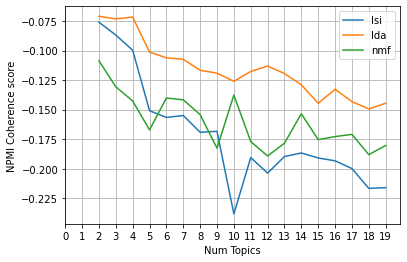

In [37]:
# Plot the NPMI scores

plt.plot(num_topic_range, lsi_npmi_scores, label='lsi')
plt.plot(num_topic_range, lda_npmi_scores, label='lda')
plt.plot(num_topic_range, nmf_npmi_scores, label='nmf')

plt.xlabel("Num Topics")
plt.ylabel("NPMI Coherence score")
plt.xticks(np.arange(0, 20, step=1))
plt.legend()
plt.grid(True)

plt.show()

### Summary of Results for NPMI-BoW Models

All graphs show a globally decreasing trend.  We use the elbow method to guide our decision for the optimal topic-number beyond which there is a dimishing return in decrease in NPMI with increasing topic-number.

Overall, LDA shows the best performance across the range of number of topics, followed by NMF and then LSI. However, LSI does better than NMF where the number of topics is lower than 6.  

The optimal number of topics for LDA appears to be 4, for NMF it is 6, and for LSI, it is 5. 

In [38]:
# LDA-Bow model for number of topics = 4
lda_model_bow4 = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=4, random_state=100 )
 
# Build the coherence models to get the scores
cm_lda_bow4 = CoherenceModel(model=lda_model_bow4, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')

get_model_results(lda_model_bow4, cm_lda_bow4, w2vectors, "LDA-BoW Model 4")

LDA-BoW Model 4
Topic 0:  ['weather', 'wind', 'barometer', 'instrument', 'state', 'bureau', 'united', 'illustration', 'use', 'storm']
Topic 1:  ['air', 'fig', 'wind', 'weather', 'illustration', 'rain', 'storm', 'pressure', 'high', 'low']
Topic 2:  ['weather', 'wind', 'cloud', 'indicate', 'storm', 'rain', 'one', 'inch', 'fig', 'air']
Topic 3:  ['air', 'wind', 'weather', 'water', 'fig', 'storm', 'cloud', 'pressure', 'temperature', 'see']

NPMI Coherence: -0.072
W2V Coherence: 0.178


(-0.072, 0.178)

### 5.2 Optimizing for W2V-Tfidf Models

In [39]:
# Computing NPMI for Tf-idf models across number of topics

w2v_scores_lda = []
w2v_scores_nmf = []
w2v_scores_lsi = []

for n in num_topic_range:
    # build the models with the given number of topics
    lda_model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n, random_state=100 )
    nmf_model = Nmf(corpus=corpus_tfidf, id2word=dictionary, num_topics=n, random_state=100 )
    lsi_model = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n)
    
    # compute the coherence_w2v scores
    lda_score = compute_c_w2v(lda_model, w2vectors)
    w2v_scores_lda.append(lda_score)
    nmf_score = compute_c_w2v(nmf_model, w2vectors) 
    w2v_scores_nmf.append(nmf_score)
    lsi_score = compute_c_w2v(lsi_model, w2vectors)
    w2v_scores_lsi.append(lsi_score)


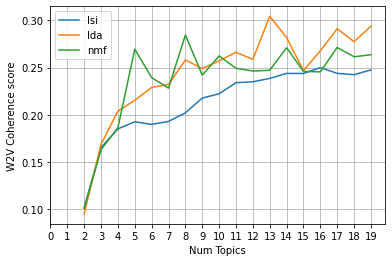

In [40]:
# Plot the W2V coherence scores
plt.plot(num_topic_range, w2v_scores_lsi, label='lsi')
plt.plot(num_topic_range, w2v_scores_lda, label='lda')
plt.plot(num_topic_range, w2v_scores_nmf, label='nmf')

plt.xlabel("Num Topics")
plt.ylabel("W2V Coherence score")
plt.xticks(np.arange(0, 20, step=1))
plt.legend()
plt.grid(True)

plt.show()

### Summary of Results for W2V-Tfidf Models

Overall, the LSI model performed worse than the other two models.  The NMF has the best performance for number of topics less than 9, but beyond that, the LDA model has the best performance for larger topic sizes.

The optimal topic size for NMF model is 8, while for LDA, it is 12.  For LSI, the number could be 5 or 9.

We would have to inspect the topics generated and their topic words in order to decide which topic number is the "best" for the model.

In [42]:
# NMF-Tfidf model for number of topics = 8
nmf_model_tfidf8 = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=8, random_state=100 )
 
# Build the coherence models to get the scores
cm_nmf_tfidf8 = CoherenceModel(model=nmf_model_tfidf8, texts=lemma_paras, dictionary=dictionary, coherence='c_npmi')

get_model_results(nmf_model_tfidf8, cm_nmf_tfidf8, w2vectors, "NMF-Tfidf Model 8")

NMF-Tfidf Model 8
Topic 0:  ['boy', 'element', 'ask', 'prophesy', 'cardboard', 'dakota', 'book', 'blizzard', 'interesting', 'physical']
Topic 1:  ['tex', 'land', 'track', 'sunshine', 'line', 'map', 'city', 'tube', 'end', 'mercury']
Topic 2:  ['inch', 'record', 'tube', 'mercury', 'temperature', 'air', 'zero', 'rainfall', 'pressure', 'sky']
Topic 3:  ['red', 'humidity', 'wind', 'air', 'weather', 'white', 'square', 'warning', 'fig', 'storm']
Topic 4:  ['vane', 'tornado', 'multiply', 'scale', 'divide', 'fahrenheit', 'centigrade', 'reaumur', 'illustration', 'thermometer']
Topic 5:  ['cloud', 'fall', 'air', 'wind', 'rain', 'see', 'within', 'rapidly', 'indicate', 'area']
Topic 6:  ['anemometer', 'velocity', 'wind', 'snow', 'connect', 'wire', 'crystal', 'illustration', 'wave', 'center']
Topic 7:  ['cloud', 'barometer', 'thunder', 'weather', 'storm', 'cirrus', 'indicate', 'color', 'wind', 'west']

NPMI Coherence: -0.273
W2V Coherence: 0.258


(-0.273, 0.258)

## 6. Conclusion

This project has  explored topic modelling on an ebook from the Gutenberg Project.  The models were: LDA, NMF, and LSI.  Two coherence metrics, NPMI and a word2vec-based metric, were used for automatic evaluation of the results of topic models. According to the evaluation by metrics, LDA was best in extracting general themes/topics from BoW data, while NMF performed best among the models extracting topics from TF-IDF data. The NMF topics were found to more specific as compared to the topics generated by LDA.

Manual labelling of the topics was found to be rather difficult, mostly because there were many overlaps in the topic words. Automatic labelling would not work well here. 

Overall, this project indicates that more often than not, topic modelling would require subjective decisions to be made on the choice of model and its parameters, as well as human judgements on appropriate labels on the topics extracted by the models.